# MP2 核坐标梯度

我们的最终目标是 XYG3 型泛函的梯度。我们已经讨论过 RHF 的核坐标梯度和 U 矩阵的计算了，现在我们就尝试进阶的 MP2 梯度。尽管 MP2 梯度也仍然不需要显式地使用 U 矩阵进行计算，但上一节中 U 矩阵的推导过程，对这一节的理解可以有很大帮助。

## 准备工作

需要注意到，我们这一节的主要目标是实现 MP2 梯度，因此前几篇文档的 `GradSCF` 在这里就要换成 `GradMP2`。

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib
from pyscf.scf import cphf
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from pyxdh.Utilities import NucCoordDerivGenerator, DipoleDerivGenerator, NumericDiff
from pyxdh.DerivOnce import GradSCF, GradMP2

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

In [3]:
gradh = GradMP2({"scf_eng": scf.RHF(mol), "cphf_tol": 1e-12})
gradh_nr = GradMP2({"scf_eng": scf.RHF(mol), "cphf_tol": 1e-12, "rotation": False})

In [4]:
nmo, nao, natm, nocc, nvir = gradh.nao, gradh.nao, gradh.natm, gradh.nocc, gradh.nvir
so, sv, sa = gradh.so, gradh.sv, gradh.sa
C, Co, Cv, e, eo, ev, D = gradh.C, gradh.Co, gradh.Cv, gradh.e, gradh.eo, gradh.ev, gradh.D
H_0_ao, S_0_ao, eri0_ao, F_0_ao = gradh.H_0_ao, gradh.S_0_ao, gradh.eri0_ao, gradh.F_0_ao
H_0_mo, S_0_mo, eri0_mo, F_0_mo = gradh.H_0_mo, gradh.S_0_mo, gradh.eri0_mo, gradh.F_0_mo

In [5]:
def to_natm_3(mat: np.ndarray):
    shape = list(mat.shape)
    shape = [int(shape[0] / 3), 3] + shape[1:]
    return mat.reshape(shape)

In [6]:
H_1_ao, S_1_ao, eri1_ao = to_natm_3(gradh.H_1_ao), to_natm_3(gradh.S_1_ao), to_natm_3(gradh.eri1_ao)
H_1_mo, S_1_mo, eri1_mo = to_natm_3(gradh.H_1_mo), to_natm_3(gradh.S_1_mo), to_natm_3(gradh.eri1_mo)

In [7]:
def grad_generator(mol):
    scf_eng = scf.RHF(mol)
    config = {"scf_eng": scf.RHF(mol), "cphf_tol": 1e-12}
    return GradMP2(config)

In [8]:
gradn = NucCoordDerivGenerator(mol, grad_generator)

除了上一篇文档在准备工作中引入的变量之外，我们再定义上一节中讨论的 U 矩阵的相关定义：

- `F_1_ao` $F_{\mu \nu}^{A_t}$, `F_1_mo` $F_{pq}^{A_t}$

- `U_1` $\mathscr{U}_{mp}^{A_t}$, `U_1_nr` $U_{mp}^{A_t}$, `U_1_vo` $U_{ai}^{A_t}$

- `B_1` $B_{pq}^{A_t}$

- `Ax0_Core` 用来计算 A 张量的缩并

In [9]:
F_1_ao, F_1_mo = to_natm_3(gradh.F_1_ao), to_natm_3(gradh.F_1_mo)
U_1, U_1_nr, U_1_vo = to_natm_3(gradh.U_1), to_natm_3(gradh_nr.U_1), to_natm_3(gradh.U_1_vo)
B_1 = to_natm_3(gradh.B_1)
Ax0_Core = gradh.Ax0_Core

## MP2 相关能与直接求导

### MP2 相关能

我们先回顾一下 MP2 相关能的计算，以及一些张量的定义。

$$
\begin{align}
E_\mathrm{MP2, c} &= T_{ij}^{ab} t_{ij}^{ab} D_{ij}^{ab} \\
T_{ij}^{ab} &= 2 t_{ij}^{ab} - t_{ij}^{ba} \\
t_{ij}^{ab} &= (ia|jb) / D_{ij}^{ab} \\
D_{ij}^{ab} &= \varepsilon_i - \varepsilon_a + \varepsilon_j - \varepsilon_b
\end{align}
$$

在 pyxdh 程序中，`T_iajb` 为 $T_{ij}^{ab}$，`t_iajb` 为 $t_{ij}^{ab}$，`D_iajb` 为 $D_{ij}^{ab}$。它们的维度信息都是 $(i, a, j, b)$。MP2 相关能需要从总能量减去 RHF 的自洽场能量 `gradh.eng - gradh.scf_eng.e_tot` 获得。

In [10]:
T_iajb, t_iajb, D_iajb = gradh.T_iajb, gradh.t_iajb, gradh.D_iajb
print("MP2 Correlation Energy:", gradh.eng - gradh.scf_eng.e_tot)

MP2 Correlation Energy: -0.2690117759995019


因此，MP2 相关能可以通过下述代码验证：

In [11]:
np.allclose(
    np.einsum("iajb, iajb, iajb -> ", T_iajb, t_iajb, D_iajb),
    gradh.eng - gradh.scf_eng.e_tot
)

True

### 直接求导法得到 MP2 梯度

一直以来，我们都是普通地使用链式法则求出能量梯度。事实上，MP2 梯度也可以通过直接的链式求导得到。我们下面就简单讨论这个问题。

首先，我们需要求出 $\varepsilon_p$ 的导数。我们上一节提到过 $\partial_{A_t} F_{pq}$ 的计算，事实上由于 $F_{pq} = \delta_{pq} \varepsilon_p$，因此其 `e_1` $\partial_{A_t} \varepsilon_p$ 的求取也就不言而喻：

$$
\varepsilon_p^{A_t} = \frac{\partial \varepsilon_p}{\partial A_t} = B_{pp}^{A_t} + A_{pp, bj} U_{bj}^{A_t}
$$

In [12]:
e_1 = B_1.diagonal(axis1=-2, axis2=-1) + Ax0_Core(sa, sa, sv, so)(U_1_vo).diagonal(axis1=-2, axis2=-1)
e_1.shape

(4, 3, 22)

<IPython.core.display.Javascript object>


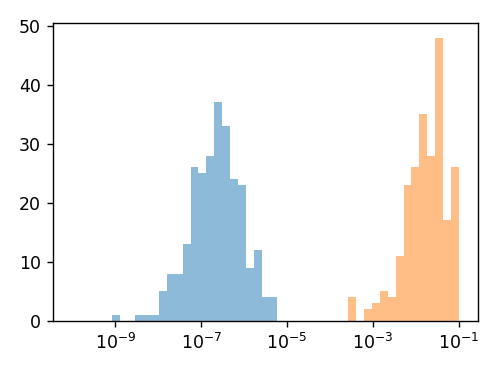

In [13]:
nd_e_0 = NumericDiff(gradn, lambda gradh: gradh.e).derivative
fig, ax = plt.subplots(figsize=(4, 3)); ax.set_xscale("log")
ax.hist(abs(e_1.ravel() - nd_e_0.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
ax.hist(abs(nd_e_0.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
fig.tight_layout()

因此，`d_D_iajb` $\partial_{A_t} D_{ij}^{ab}$ 可以写为

$$
\frac{\partial D_{ij}^{ab}}{\partial A_t} = \frac{\partial \varepsilon_i}{\partial A_t} - \frac{\partial \varepsilon_a}{\partial A_t} + \frac{\partial \varepsilon_j}{\partial A_t} - \frac{\partial \varepsilon_b}{\partial A_t}
$$

In [14]:
d_D_iajb = e_1[:, :, so, None, None, None] - e_1[:, :, None, sv, None, None] + e_1[:, :, None, None, so, None] - e_1[:, :, None, None, None, sv]
d_D_iajb.shape

(4, 3, 9, 13, 9, 13)

<IPython.core.display.Javascript object>


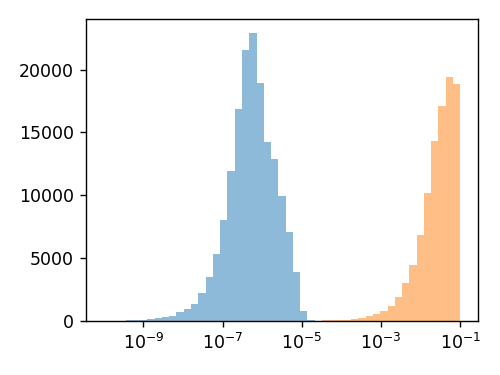

In [15]:
nd_D_iajb = NumericDiff(gradn, lambda gradh: gradh.D_iajb).derivative
fig, ax = plt.subplots(figsize=(4, 3)); ax.set_xscale("log")
ax.hist(abs(d_D_iajb.ravel() - nd_D_iajb.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
ax.hist(abs(nd_D_iajb.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
fig.tight_layout()

随后我们给出导数 `d_eri0_iajb` $\partial_{A_t} (ia|jb)$：

$$
\partial_{A_t} (ia|jb) = (ia|jb)^{A_t} + (ma|jb) U_{mi}^{A_t} + (im|jb) U_{ma}^{A_t} + (ia|mb) U_{mj}^{A_t} + (ia|jm) U_{mb}^{A_t}
$$

需要注意到，这里需要使用未经轨道旋转的 $U_{mp}^{A_t}$ 而不能是经过轨道旋转的 $\mathscr{U}_{mp}^{A_t}$：

In [16]:
d_eri0_iajb = (
    + eri1_mo[:, :, so, sv, so, sv]
    + np.einsum("majb, Atmi -> Atiajb", eri0_mo[sa, sv, so, sv], U_1_nr[:, :, sa, so])
    + np.einsum("imjb, Atma -> Atiajb", eri0_mo[so, sa, so, sv], U_1_nr[:, :, sa, sv])
    + np.einsum("iamb, Atmj -> Atiajb", eri0_mo[so, sv, sa, sv], U_1_nr[:, :, sa, so])
    + np.einsum("iajm, Atmb -> Atiajb", eri0_mo[so, sv, so, sa], U_1_nr[:, :, sa, sv])
)
d_eri0_iajb.shape

(4, 3, 9, 13, 9, 13)

<IPython.core.display.Javascript object>


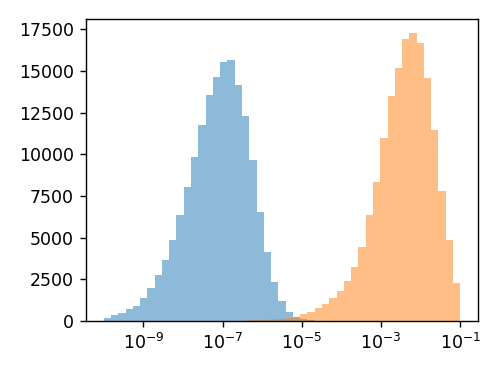

In [17]:
nd_eri0_iajb = NumericDiff(gradn, lambda gradh: gradh.eri0_mo[so, sv, so, sv]).derivative
fig, ax = plt.subplots(figsize=(4, 3)); ax.set_xscale("log")
ax.hist(abs(d_eri0_iajb.ravel() - nd_eri0_iajb.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
ax.hist(abs(nd_eri0_iajb.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
fig.tight_layout()

有了 `d_D_iajb` $\partial_{A_t} D_{ij}^{ab}$ 与 `d_eri0_iajb` $\partial_{A_t} (ia|jb)$ 后，我们就可以求取 `d_t_iajb` $\partial_{A_t} t_{ij}^{ab}$：

$$
\frac{\partial t_{ij}^{ab}}{\partial A_t} = \frac{\partial_{A_t} (ia|jb)}{D_{ij}^{ab}} - \frac{(ia|jb) \cdot \partial_{A_t} D_{ij}^{ab}}{(D_{ij}^{ab})^2}
$$

In [18]:
d_t_iajb = (d_eri0_iajb / D_iajb - eri0_mo[so, sv, so, sv] * d_D_iajb / D_iajb**2)
d_t_iajb.shape

(4, 3, 9, 13, 9, 13)

<IPython.core.display.Javascript object>


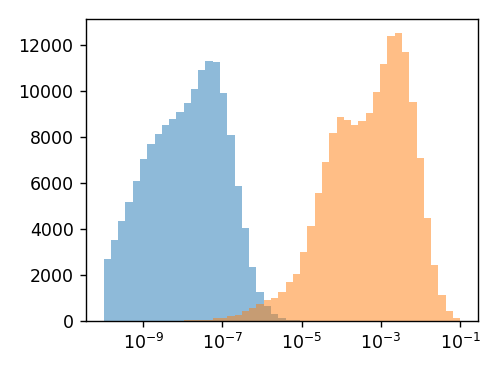

In [19]:
nd_t_iajb = NumericDiff(gradn, lambda gradh: gradh.t_iajb).derivative
fig, ax = plt.subplots(figsize=(4, 3)); ax.set_xscale("log")
ax.hist(abs(d_t_iajb.ravel() - nd_t_iajb.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
ax.hist(abs(nd_t_iajb.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
fig.tight_layout()

由于 $T_{ij}^{ab} = 2 t_{ij}^{ab} - t_{ij}^{ba}$，因此 `d_T_iajb` $\partial_{A_t} T_{ij}^{ab} = 2 \partial_{A_t} t_{ij}^{ab} - \partial_{A_t} t_{ij}^{ba}$：

In [20]:
d_T_iajb = 2 * d_t_iajb - d_t_iajb.swapaxes(-1, -3)

由此，我们可以得到 `E_1_MP2_contrib`

$$
\frac{\partial E_\mathrm{MP2, c}}{\partial A_t} = \partial_{A_t} T_{ij}^{ab} t_{ij}^{ab} D_{ij}^{ab} + T_{ij}^{ab} \partial_{A_t} t_{ij}^{ab} D_{ij}^{ab} + T_{ij}^{ab} t_{ij}^{ab} \partial_{A_t} D_{ij}^{ab}
$$

In [21]:
E_1_MP2_contrib = (
    + d_T_iajb * t_iajb * D_iajb
    + T_iajb * d_t_iajb * D_iajb
    + T_iajb * t_iajb * d_D_iajb
).sum(axis=(-1, -2, -3, -4))
E_1_MP2_contrib

array([[ 0.03581, -0.00086,  0.05372],
       [-0.00427,  0.02169, -0.06404],
       [-0.03018, -0.00096, -0.00777],
       [-0.00137, -0.01988,  0.01809]])

上面是 MP2 相关能的梯度贡献大小。而对于总能量而言，$\partial_{A_t} E = \partial_{A_t} E_\mathrm{RHF} + \partial_{A_t} E_\mathrm{MP2, c}$，因此我们还需要补上 RHF 的总梯度贡献 $\partial_{A_t} E_\mathrm{RHF}$。

这里我们可以借助于 `GradMP2` 继承于 `GradSCF` 类，使用两种程序的小技巧，来从 MP2 梯度计算实例 `gradh` 中提出 RHF 部分的梯度。一种方法是使用 python 自带的 `super` 函数调出父类的梯度计算函数 `_get_E_1`：

In [22]:
super(GradMP2, gradh)._get_E_1()

array([[-0.06727,  0.06951,  0.0961 ],
       [ 0.01291,  0.14195, -0.11756],
       [ 0.03423,  0.01409,  0.03949],
       [ 0.02013, -0.22555, -0.01803]])

但上述方法在 [菱形继承](../intro/intro_python.ipynb#菱形继承) 关系下时容易出错。另一种更清晰稳妥的做法是

In [23]:
GradSCF._get_E_1(gradh)

array([[-0.06727,  0.06951,  0.0961 ],
       [ 0.01291,  0.14195, -0.11756],
       [ 0.03423,  0.01409,  0.03949],
       [ 0.02013, -0.22555, -0.01803]])

将 RHF 部分与 MP2 相关能部分的贡献相加，即可得到总 MP2 梯度：

In [24]:
GradSCF._get_E_1(gradh) + E_1_MP2_contrib

array([[-0.03146,  0.06865,  0.14982],
       [ 0.00864,  0.16364, -0.1816 ],
       [ 0.00405,  0.01313,  0.03173],
       [ 0.01876, -0.24543,  0.00006]])

这也与 pyxdh 所给出的总梯度一致：

In [25]:
gradh.E_1

array([[-0.03146,  0.06865,  0.14982],
       [ 0.00864,  0.16364, -0.1816 ],
       [ 0.00405,  0.01313,  0.03173],
       [ 0.01876, -0.24543,  0.00006]])

我们可以用总 MP2 能量的数值梯度来验证上面计算的解析梯度：

In [26]:
d_E_0 = NumericDiff(gradn, lambda gradh: gradh.eng).derivative.reshape(natm, 3)
np.allclose(GradSCF._get_E_1(gradh) + E_1_MP2_contrib, d_E_0)

True

但需要知道，上述的计算过程较为耗时，多次使用多个四维或高维张量的缩并，不适合作为一般 MP2 梯度计算的方法，因此我们会换用另一种看起来更复杂的做法。尽管我们后文所使用的计算方法也仍然是需要四维或高维张量的存储与缩并，但它可以较为容易地被量化程序优化到两维度的存储复杂度。

## MP2 一阶梯度常规做法

常规来说，MP2 相关能梯度分为三部分考虑 (Aikens, eq.24)

$$
\partial_\mathbb{A} E_\mathrm{MP2, c} = D_{pq}^\mathrm{MP2} h_{pq}^\mathbb{A} + W_{pq}^\mathrm{MP2} S_{pq}^\mathbb{A} + \Gamma_{\mu \nu \kappa \lambda}^\mathrm{MP2} (\mu \nu | \kappa \lambda)^\mathbb{A}
$$

后文中，我们分别称三部分为弛豫密度贡献、加权密度贡献、以及双粒子密度贡献。但在 pyxdh 中，我们使用下述方式来实现 MP2 相关能梯度：

$$
\partial_\mathbb{A} E_\mathrm{MP2, c} = D_{pq}^\mathrm{MP2} B_{pq}^\mathbb{A} + W_{pq}^\mathrm{MP2} [\mathrm{I}] S_{pq}^\mathbb{A} + \Gamma_{\mu \nu \kappa \lambda}^\mathrm{MP2} (\mu \nu | \kappa \lambda)^\mathbb{A} \tag{1}
$$

我们将会用我们的记号，简单地推导上式并作程序实现。由于 MP2 梯度的推导几乎是连贯的，因此这一节的分段会相当少。

### 公式重述与 $\Gamma_{\mu \nu \kappa \lambda}^\mathrm{MP2} (\mu \nu | \kappa \lambda)^\mathbb{A}$

我们回顾到 MP2 相关能的另一种定义方式：

$$
E_\mathrm{MP2, c} = \big( 2 (ia|jb) - (ib|ja) \big) (ia|jb) (D_{ij}^{ab})^{-1}
$$

In [27]:
np.einsum("iajb, iajb, iajb -> ", 2 * eri0_mo[so, sv, so, sv] - eri0_mo[so, sv, so, sv].swapaxes(-1, -3), eri0_mo[so, sv, so, sv], D_iajb**-1)

-0.26901177599951337

以此为前提，我们推导 MP2 相关能梯度。

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&= \big( 2 \partial_\mathbb{A} (ia|jb) - \partial_\mathbb{A} (ib|ja) \big) (ia|jb) (D_{ij}^{ab})^{-1} \\
&\quad + \big( 2 (ia|jb) - (ib|ja) \big) \partial_\mathbb{A} (ia|jb) (D_{ij}^{ab})^{-1} \\
&\quad + \big( 2 (ia|jb) - (ib|ja) \big) (ia|jb) \partial_\mathbb{A} (D_{ij}^{ab})^{-1} \tag{2} \\
\end{align}
$$

我们先讨论第一项。由于上式是对 $i, a, j, b$ 求和的，因此角标 $a, b$ 是可以交换的；因此

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&\leftarrow \big( 2 \partial_\mathbb{A} (ia|jb) - \partial_\mathbb{A} (ib|ja) \big) (ia|jb) (D_{ij}^{ab})^{-1} \\
&= \big( 2 \partial_\mathbb{A} (ia|jb) \cdot (ia|jb) - \partial_\mathbb{A} (ib|ja) \cdot (ia|jb) \big) (D_{ij}^{ab})^{-1} \\
&= \big( 2 \partial_\mathbb{A} (ia|jb) \cdot (ia|jb) - \partial_\mathbb{A} (ia|jb) \cdot (ib|ja) \big) (D_{ij}^{ab})^{-1} \\
&= \big( 2 (ia|jb) - (ib|ja) \big) \partial_\mathbb{A} (ia|jb) (D_{ij}^{ab})^{-1} \\
&= T_{ij}^{ab} \partial_\mathbb{A} (ia|jb)
\end{align}
$$

这就与式 (2) 贡献项中的第二项相等了。而对于式 (2) 的第三项，则有

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&\leftarrow \big( 2 (ia|jb) - (ib|ja) \big) (ia|jb) \partial_\mathbb{A} (D_{ij}^{ab})^{-1} \\
&= - \big( 2 (ia|jb) - (ib|ja) \big) (ia|jb) \cdot (D_{ij}^{ab})^{-2} \partial_\mathbb{A} D_{ij}^{ab} \\
&= - T_{ij}^{ab} t_{ij}^{ab} (\varepsilon_i^\mathbb{A} + \varepsilon_j^\mathbb{A} - \varepsilon_a^\mathbb{A} - \varepsilon_b^\mathbb{A}) \\
&= - 2 T_{ij}^{ab} t_{ij}^{ab} (\varepsilon_i^\mathbb{A} - \varepsilon_a^\mathbb{A})
\end{align}
$$

<div class="alert alert-info">

**任务 (1)**

证明 (不采用 Einstein Summation)

$$
\sum_{ijab} t_{ij}^{ab} T_{ij}^{ab} \varepsilon_i^\mathbb{A} = \sum_{ijab} t_{ij}^{ab} T_{ij}^{ab} \varepsilon_j^\mathbb{A}
$$

</div>

综合上述两个结果，我们进一步得到

$$
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}} = 2 T_{ij}^{ab} \partial_\mathbb{A} (ia|jb) - 2 T_{ij}^{ab} t_{ij}^{ab} (\varepsilon_i^\mathbb{A} - \varepsilon_a^\mathbb{A}) \tag{3}
$$

下面我们先处理 $2 T_{ij}^{ab} \partial_\mathbb{A} (ia|jb)$ 一项：

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&\leftarrow 2 T_{ij}^{ab} \partial_\mathbb{A} (ia|jb) \\
&= \color{red}{2 T_{ij}^{ab} (ia|jb)^\mathbb{A}} + \color{blue}{2 U_{mi}^\mathbb{A} (ma|jb) T_{ij}^{ab}} + 2 U_{ma}^\mathbb{A} (im|jb) T_{ij}^{ab} + \color{blue}{2 U_{mj}^\mathbb{A} (ia|mb) T_{ij}^{ab}} + 2 U_{mb}^\mathbb{A} (ia|jm) T_{ij}^{ab} \tag{4}
\end{align}
$$

我们先看式 (4) 红色项。我们若定义

$$
\Gamma_{\mu \nu \kappa \lambda}^\mathrm{MP2} = 2 T_{ij}^{ab} C_{\mu i} C_{\nu a} C_{\kappa j} C_{\lambda b} \tag{5}
$$

那么，我们就给出了式 (1) 中的第 3 个 $\partial_\mathbb{A} E_\mathrm{MP2, c}$ 贡献项 $\Gamma_{\mu \nu \kappa \lambda}^\mathrm{MP2} (\mu \nu | \kappa \lambda)^\mathbb{A}$ `E_1_MP2_contrib3`。尽管在其它量化程序中可能会确实地求出 $\Gamma_{\mu \nu \kappa \lambda}^\mathrm{MP2}$；但事实上，在 pyxdh 中该 MP2 梯度贡献还是通过 $2 T_{ij}^{ab} (ia|jb)^\mathbb{A}$ 得到的。

In [28]:
E_1_MP2_contrib3 = 2 * np.einsum("iajb, Atiajb -> At", T_iajb, eri1_mo[:, :, so, sv, so, sv])
E_1_MP2_contrib3

array([[ 0.01888,  0.00077,  0.02607],
       [-0.00123,  0.01517, -0.04045],
       [-0.01616, -0.00135,  0.00038],
       [-0.0015 , -0.01459,  0.014  ]])

### U 矩阵占据-占据、非占-非占部分的消除

之所以我们需要消除 U 矩阵占据-占据、非占-非占部分，是因为这些分块的 U 矩阵会出现数值问题。U 矩阵的数值问题我们在上一篇文档中已经有所讨论。我们这里列举两种 U 矩阵占据-占据的消除方式。

- 利用对称性。譬如对于矩阵 $X_{ij} = X_{ji}$：

    $$
    \sum_{ij} U_{ij}^\mathbb{A} X_{ij}
    = \frac{1}{2} \sum_{ij} U_{ij}^\mathbb{A} (X_{ij} + X_{ji})
    = \frac{1}{2} \sum_{ij} (U_{ij}^\mathbb{A} + U_{ji}^\mathbb{A}) X_{ij}
    = - \frac{1}{2} \sum_{ij} S_{ij}^\mathbb{A} X_{ij}
    $$

- 利用 $\partial_\mathbb{A} F_{ij} = \delta_{ij} \varepsilon_i^\mathbb{A}$：

    $$
    (\varepsilon_i - \varepsilon_j) U_{ij}^\mathbb{A} = \sum_{ck} \big( - B_{ij}^\mathbb{A} - A_{ij, ck} U_{ck}^\mathbb{A} \big)
    $$

非占-非占部分的消除也是相同的。

看式 (4) 的蓝色项。首先根据求和角标 $(i, j, a, b)$ 和 ERI 积分的对称性，可知两个蓝色项完全相等，即

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&\leftarrow 2 U_{mi}^\mathbb{A} (ma|jb) T_{ij}^{ab} + 2 U_{mj}^\mathbb{A} (ia|mb) T_{ij}^{ab} \\
&= 4 U_{mi}^\mathbb{A} (ma|jb) T_{ij}^{ab} \\
&= \color{red}{4 U_{ki}^\mathbb{A} (ka|jb) T_{ij}^{ab}} + 4 U_{ci}^\mathbb{A} (ca|jb) T_{ij}^{ab} \tag{6}
\end{align}
$$

我们对红色项作进一步讨论。我们有

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&\leftarrow 4 U_{ki}^\mathbb{A} (ka|jb) T_{ij}^{ab} \\
&= 2 U_{ki}^\mathbb{A} (ka|jb) T_{ij}^{ab} - 2 U_{ik}^\mathbb{A} (ka|jb) T_{ij}^{ab} - 2 S_{ik}^\mathbb{A} (ka|jb) T_{ij}^{ab} \\
&= 2 U_{ki}^\mathbb{A} (ka|jb) T_{ij}^{ab} - 2 U_{ki}^\mathbb{A} (ia|jb) T_{kj}^{ab} - 2 S_{ik}^\mathbb{A} (ka|jb) T_{ij}^{ab} \\
&= 2 U_{ki}^\mathbb{A} t_{kj}^{ab} D_{kj}^{ab} T_{ij}^{ab} - 2 U_{ki}^\mathbb{A} t_{ij}^{ab} D_{ij}^{ab} T_{kj}^{ab} - 2 S_{ik}^\mathbb{A} (ka|jb) T_{ij}^{ab} \\
&= 2 U_{ki}^\mathbb{A} (D_{kj}^{ab} - D_{ij}^{ab}) t_{ij}^{ab} T_{kj}^{ab} - 2 S_{ik}^\mathbb{A} (ka|jb) T_{ij}^{ab} \\
&= 2 U_{ki}^\mathbb{A} (\varepsilon_k - \varepsilon_i) t_{ij}^{ab} T_{kj}^{ab} - 2 S_{ik}^\mathbb{A} (ka|jb) T_{ij}^{ab} \\
&= 2 \big( (\varepsilon_k - \varepsilon_i) U_{ki}^\mathbb{A} + A_{ki, cl} U_{cl}^\mathbb{A} + B_{ki}^\mathbb{A} \big) t_{ij}^{ab} T_{kj}^{ab} - 2 \big( A_{ki, cl} U_{cl}^\mathbb{A} + B_{ki}^\mathbb{A} \big) t_{ij}^{ab} T_{kj}^{ab} - 2 S_{ik}^\mathbb{A} (ka|jb) T_{ij}^{ab} \\
&= 2 \delta_{ik} \varepsilon_i^\mathbb{A} t_{ij}^{ab} T_{kj}^{ab} - 2 \big( A_{ki, cl} U_{cl}^\mathbb{A} + B_{ki}^\mathbb{A} \big) t_{ij}^{ab} T_{kj}^{ab} - 2 S_{ik}^\mathbb{A} (ka|jb) T_{ij}^{ab} \\
&= 2 \varepsilon_i^\mathbb{A} t_{ij}^{ab} T_{ij}^{ab} - 2 \big( A_{ki, cl} U_{cl}^\mathbb{A} + B_{ki}^\mathbb{A} \big) t_{ij}^{ab} T_{kj}^{ab} - 2 S_{ik}^\mathbb{A} (ka|jb) T_{ij}^{ab} \\
&= 2 T_{ij}^{ab} t_{ij}^{ab} \varepsilon_i^\mathbb{A} - 2 U_{dl}^\mathbb{A} A_{dl, ij} T_{ik}^{ab} t_{jk}^{ab} - 2 B_{ij}^\mathbb{A} T_{ik}^{ab} t_{jk}^{ab} - 2 S_{ij}^\mathbb{A} T_{ik}^{ab} (ja|kb)
\end{align}
$$

上式的推导很长，我们将推导利用到的结论列举如下：

- 等号 1：利用 $U_{ki}^\mathbb{A} + U_{ik}^\mathbb{A} + S_{ik}^\mathbb{A} = 0$；

- 等号 2：利用求和中 $i, k$ 角标可交换；

- 等号 3：利用定义导出式 $(ia|jb) = t_{ij}^{ab} D_{ij}^{ab}$；

- 等号 4：参考下面任务 (2) 的证明思路；

- 等号 5：直接套用 $D_{ij}^{ab} = \varepsilon_i + \varepsilon_j - \varepsilon_a - \varepsilon_b$；

- 等号 7：利用 $\partial_\mathbb{A} F_{ik} = (\varepsilon_k - \varepsilon_i) U_{ki}^\mathbb{A} + A_{ki, cl} U_{cl}^\mathbb{A} + B_{ki}^\mathbb{A} = \delta_{ik} \varepsilon_i^\mathbb{A}$

- 等号 9：仅仅是交换与更换了一些角标，并利用了 $A_{pq, rs} = A_{rs, pq}$ 的对称性。

<div class="alert alert-info">

**任务 (2)**

证明 (不采用 Einstein Summation)

$$
\sum_{ijkab} t_{ij}^{ab} T_{kj}^{ab} = \sum_{ijkab} t_{kj}^{ab} T_{ij}^{ab}
$$

</div>

该推导很长，我们可以从程序上验证一下正确性：

$$
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
\leftarrow 4 U_{ki}^\mathbb{A} (ka|jb) T_{ij}^{ab}
= 2 T_{ij}^{ab} t_{ij}^{ab} \varepsilon_i^\mathbb{A} - 2 U_{dl}^\mathbb{A} A_{dl, ij} T_{ik}^{ab} t_{jk}^{ab} - 2 B_{ij}^\mathbb{A} T_{ik}^{ab} t_{jk}^{ab} - 2 S_{ij}^\mathbb{A} T_{ik}^{ab} (ja|kb)
$$

In [29]:
4 * np.einsum("Atki, kajb, iajb -> At", U_1_nr[:, :, so, so], eri0_mo[so, sv, so, sv], T_iajb)

array([[ 0.01297, -0.00873, -0.01071],
       [-0.00166,  0.01218,  0.00496],
       [-0.01077, -0.0003 , -0.00653],
       [-0.00055, -0.00315,  0.01228]])

In [30]:
(
    + 2 * np.einsum("iajb, iajb, Ati -> At", T_iajb, t_iajb, e_1[:, :, so])
    - 2 * np.einsum("Atdl, dl -> At", U_1_vo, Ax0_Core(sv, so, so, so)(np.einsum("iakb, jakb -> ij", T_iajb, t_iajb)))
    - 2 * np.einsum("Atij, iakb, jakb -> At", B_1[:, :, so, so], T_iajb, t_iajb)
    - 2 * np.einsum("Atij, iakb, jakb -> At", S_1_mo[:, :, so, so], T_iajb, eri0_mo[so, sv, so, sv])
)

array([[ 0.01297, -0.00873, -0.01071],
       [-0.00166,  0.01218,  0.00496],
       [-0.01077, -0.0003 , -0.00653],
       [-0.00055, -0.00315,  0.01228]])

因此，我们可以将式 (4) 的蓝色项写为

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&\leftarrow 2 U_{mi}^\mathbb{A} (ma|jb) T_{ij}^{ab} + 2 U_{mj}^\mathbb{A} (ia|mb) T_{ij}^{ab} \\
&= 2 T_{ij}^{ab} t_{ij}^{ab} \varepsilon_i^\mathbb{A} + \color{red}{U_{dl}^\mathbb{A} \big( - 2 A_{dl, ij} T_{ik}^{ab} t_{jk}^{ab} + 4 T_{lj}^{ab} (da|jb) \big) - 2 B_{ij}^\mathbb{A} T_{ik}^{ab} t_{jk}^{ab}} \color{blue}{- 2 S_{ij}^\mathbb{A} T_{ik}^{ab} (ja|kb)} \tag{7}
\end{align}
$$

类似地，我们会将式 (4) 的黑色项写为

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&\leftarrow 2 U_{ma}^\mathbb{A} (im|jb) T_{ij}^{ab} + 2 U_{mb}^\mathbb{A} (ia|jm) T_{ij}^{ab} = 4 U_{ma}^\mathbb{A} (im|jb) T_{ij}^{ab} \\
&= - 2 T_{ij}^{ab} t_{ij}^{ab} \varepsilon_a^\mathbb{A} + \color{red}{U_{dl}^\mathbb{A} \big( 2 A_{dl, ab} T_{ij}^{ac} t_{ij}^{bc} - 4 T_{ij}^{db} (il|jb) \big) + 2 B_{ab}^\mathbb{A} T_{ij}^{ac} t_{ij}^{bc}} \color{blue}{- 2 S_{ab}^\mathbb{A} T_{ij}^{ac} (ib|jc) - 4 S_{ai}^\mathbb{A} T_{jk}^{ab} (ij|bk)} \tag{8}
\end{align}
$$

<div class="alert alert-info">

**演示 (1) 连续公式推导与程序的相互验证**

我们将会按上文的推导方式，展示式 (8) 的推导。但这么复杂的推导很容易出现失误，我们事实上可以依靠程序来增加公式推导的容错率。这种做法也相当多地应用在 pyxdh 整个程序的开发中。

</div>

现在我们综合考虑 (3), (4), (7), (8)，我们就发现所有与 $\varepsilon_p^\mathbb{A}$ 的项就都消去，并得到：

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&= \color{green}{2 T_{ij}^{ab} \partial_\mathbb{A} (ia|jb)} \\
&\quad \color{red}{+ U_{dl}^\mathbb{A} \big( - 2 A_{dl, ij} T_{ik}^{ab} t_{jk}^{ab} + 2 A_{dl, ab} T_{ij}^{ac} t_{ij}^{bc} + 4 T_{lj}^{ab} (da|jb) - 4 T_{ij}^{db} (il|jb) \big)} \\
&\quad \color{red}{- 2 B_{ij}^\mathbb{A} T_{ik}^{ab} t_{jk}^{ab} + 2 B_{ab}^\mathbb{A} T_{ij}^{ac} t_{ij}^{bc}} \\
&\quad \color{blue}{- 2 S_{ij}^\mathbb{A} T_{ik}^{ab} (ja|kb) - 2 S_{ab}^\mathbb{A} T_{ij}^{ac} (ib|jc) - 4 S_{ai}^\mathbb{A} T_{jk}^{ab} (ij|bk)} \tag{9}
\end{align}
$$

在前几篇文档所规定的符号体系下，这应当近乎于是最简化了的、消除了 $U_{ij}^\mathbb{A}$ 与 $U_{ab}^\mathbb{A}$ 的 MP2 相关能梯度表达了。用程序可以编写如下：

In [31]:
(
    # Line 1
    + 2 * np.einsum("iajb, Atiajb -> At", T_iajb, eri1_mo[:, :, so, sv, so, sv])
    # Line 2
    - 2 * np.einsum("Atdl, dl -> At", U_1_vo, Ax0_Core(sv, so, so, so)(np.einsum("iakb, jakb -> ij", T_iajb, t_iajb)))
    + 2 * np.einsum("Atdl, dl -> At", U_1_vo, Ax0_Core(sv, so, sv, sv)(np.einsum("iajc, ibjc -> ab", T_iajb, t_iajb)))
    + 4 * np.einsum("Atdl, lajb, dajb -> At", U_1_vo, T_iajb, eri0_mo[sv, sv, so, sv])
    - 4 * np.einsum("Atdl, idjb, iljb -> At", U_1_vo, T_iajb, eri0_mo[so, so, so, sv])
    # Line 3
    - 2 * np.einsum("Atij, iakb, jakb -> At", B_1[:, :, so, so], T_iajb, t_iajb)
    + 2 * np.einsum("Atab, iajc, ibjc -> At", B_1[:, :, sv, sv], T_iajb, t_iajb)
    # Line 4
    - 2 * np.einsum("Atij, iakb, jakb -> At", S_1_mo[:, :, so, so], T_iajb, eri0_mo[so, sv, so, sv])
    - 2 * np.einsum("Atab, iajc, ibjc -> At", S_1_mo[:, :, sv, sv], T_iajb, eri0_mo[so, sv, so, sv])
    - 4 * np.einsum("Atai, jakb, ijbk -> At", S_1_mo[:, :, sv, so], T_iajb, eri0_mo[so, so, sv, so])
)

array([[ 0.03581, -0.00086,  0.05372],
       [-0.00427,  0.02169, -0.06404],
       [-0.03018, -0.00096, -0.00777],
       [-0.00137, -0.01988,  0.01809]])

我们能看到上述程序确实与我们曾经计算过的 $\partial_\mathbb{A} E_\mathrm{MP2, c}$ `E_1_MP2_contrib` 相同。

In [32]:
E_1_MP2_contrib

array([[ 0.03581, -0.00086,  0.05372],
       [-0.00427,  0.02169, -0.06404],
       [-0.03018, -0.00096, -0.00777],
       [-0.00137, -0.01988,  0.01809]])

式 (9) 中，绿色部分就是双粒子密度贡献 $2 T_{ij}^{ab} \partial_\mathbb{A} (ia|jb)$ `E_1_MP2_contrib3`，我们已经实现过了；而红色项是 $D_{pq}^\mathrm{MP2} B_{pq}^\mathbb{A}$ `E_1_MP2_contrib1`，蓝色项是 $W_{pq}^\mathrm{MP2} [\mathrm{I}] S_{pq}^\mathbb{A}$ `E_1_MP2_contrib2`。下面我们会定义这些变量，对 MP2 的梯度表达式进行化简。

### $W_{pq}^\mathrm{MP2} [\mathrm{I}] S_{pq}^\mathbb{A}$

我们定义，

$$
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}} \leftarrow W_{pq}^\mathrm{MP2} [\mathrm{I}] S_{pq}^\mathbb{A} = - 2 S_{ij}^\mathbb{A} T_{ik}^{ab} (ja|kb) - 2 S_{ab}^\mathbb{A} T_{ij}^{ac} (ib|jc) - 4 S_{ai}^\mathbb{A} T_{jk}^{ab} (ij|bk)
$$

其中，`W_I` $W_{pq}^\mathrm{MP2} [\mathrm{I}]$ 是一个分块拼凑出来的、非对称的矩阵。它的原型是加权密度矩阵 $W_{pq}^\mathrm{MP2}$，但 pyxdh 有意为简化公式表达，不计算全部加权密度矩阵，而只保留其中的第一部分：(Aikens, eq.181 - eq.183)

\begin{equation}
\begin{aligned}
W_{ij}^\mathrm{MP2} [\mathrm{I}] &= - 2 T_{ik}^{ab} (ja|kb) \\
W_{ab}^\mathrm{MP2} [\mathrm{I}] &= - 2 T_{ij}^{ac} (ib|jc) \\
W_{ai}^\mathrm{MP2} [\mathrm{I}] &= - 4 T_{jk}^{ab} (ij|bk) \\
W_{ia}^\mathrm{MP2} [\mathrm{I}] &= 0
\end{aligned} \tag{10}
\end{equation}

In [33]:
W_I = np.zeros((nmo, nmo))
W_I = np.zeros((nmo, nmo))
W_I[so, so] = - 2 * np.einsum("iakb, jakb -> ij", T_iajb, eri0_mo[so, sv, so, sv])
W_I[sv, sv] = - 2 * np.einsum("iajc, ibjc -> ab", T_iajb, eri0_mo[so, sv, so, sv])
W_I[sv, so] = - 4 * np.einsum("jakb, ijbk -> ai", T_iajb, eri0_mo[so, so, sv, so])
W_I.shape

(22, 22)

留意到该矩阵与被求导量 $\mathbb{A}$ 无关，因此可以看成与分子和方法有关的内秉性质。在 pyxdh 中，其对应的 property 是 `W_I`：

In [34]:
np.allclose(W_I, gradh.W_I)

True

因此，`E_1_MP2_contrib2` $W_{pq}^\mathrm{MP2} [\mathrm{I}] S_{pq}^\mathbb{A}$ 可以写为

In [35]:
E_1_MP2_contrib2 = np.einsum("pq, Atpq -> At", W_I, S_1_mo)
E_1_MP2_contrib2

array([[-0.00323, -0.00809, -0.00192],
       [-0.00236, -0.00146,  0.00845],
       [ 0.0028 ,  0.00276, -0.00533],
       [ 0.00279,  0.00679, -0.0012 ]])

### $D_{pq}^\mathrm{MP2} B_{pq}^\mathbb{A}$ 与 Z-Vector 方法

我们定义，

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&\leftarrow D_{pq}^\mathrm{MP2} B_{pq}^\mathbb{A} \\
&= + U_{dl}^\mathbb{A} \big( - 2 A_{dl, ij} T_{ik}^{ab} t_{jk}^{ab} + 2 A_{dl, ab} T_{ij}^{ac} t_{ij}^{bc} + 4 T_{lj}^{ab} (da|jb) - 4 T_{ij}^{db} (il|jb) \big) \\
&\quad - 2 B_{ij}^\mathbb{A} T_{ik}^{ab} t_{jk}^{ab} + 2 B_{ab}^\mathbb{A} T_{ij}^{ac} t_{ij}^{bc}
\end{align}
$$

其中，`D_r` $D_{pq}^\mathrm{MP2}$ 代表 MP2 的弛豫密度 (它不包含 SCF 密度部分)。它同 $W_{pq} [\mathrm{I}]$ 一样，与被求导量 $\mathbb{A}$ 无关；但它的导出稍复杂。

我们首先定义 `D_r_oovv` $D_{pq}^\text{MP2, oo-vv}$ 即 $D_{pq}^\mathrm{MP2}$ 的占据-占据与非占-非占部分；它仅仅是为了程序方便而用：(Aikens, eq.177 - eq.178)

\begin{equation}
\begin{aligned}
D_{ij}^\text{MP2} &= - 2 T_{ik}^{ab} t_{jk}^{ab} \\
D_{ab}^\text{MP2} &= 2 T_{ij}^{ac} t_{ij}^{bc} \\
\end{aligned} \tag{11}
\end{equation}

In [36]:
D_r_oovv = np.zeros((nmo, nmo))
D_r_oovv[so, so] = - 2 * np.einsum("iakb, jakb -> ij", T_iajb, t_iajb)
D_r_oovv[sv, sv] = 2 * np.einsum("iajc, ibjc -> ab", T_iajb, t_iajb)

那么，

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
\leftarrow D_{pq}^\mathrm{MP2} B_{pq}^\mathbb{A}
= U_{dl}^\mathbb{A} \big( A_{dl, pq} D_{pq}^\text{MP2, oo-vv} + 4 T_{lj}^{ab} (da|jb) - 4 T_{ij}^{db} (il|jb) \big) + B_{pq}^\mathbb{A} D_{pq}^\text{MP2, oo-vv}
\end{align}
$$

随后，我们会定义 `L` L 矩阵；它也与被求导量 $\mathbb{A}$ 无关：(Aikens, eq.159)

$$
\begin{align}
L_{ai} &= A_{ai, kl} D_{kl}^\mathrm{MP2} + A_{ai, bc} D_{bc}^\mathrm{MP2} - 4 T_{jk}^{ab} (ij|bk) + 4 T_{ij}^{bc} (ab|jc) \\
&= A_{ai, pq} D_{pq}^\mathrm{MP2, oo-vv} - 4 T_{jk}^{ab} (ij|bk) + 4 T_{ij}^{bc} (ab|jc)
\end{align}
$$

In [37]:
L = (
    + Ax0_Core(sv, so, sa, sa)(D_r_oovv)
    - 4 * np.einsum("jakb, ijbk -> ai", T_iajb, eri0_mo[so, so, sv, so])
    + 4 * np.einsum("ibjc, abjc -> ai", T_iajb, eri0_mo[sv, sv, so, sv])
)

那么，

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
\leftarrow D_{pq}^\mathrm{MP2} B_{pq}^\mathbb{A}
= U_{ai}^\mathbb{A} L_{ai} + B_{pq}^\mathbb{A} D_{pq}^\text{MP2, oo-vv}
\end{align}
$$

下面我们用 Z-Vector 方法，对上式中的 $U_{ai}^\mathbb{A} L_{ai}$ 作处理。(Aikens, eq.58 - eq.64)

上一篇 [文档](grad_rhf_U.ipynb#演示-(1)-矩阵求逆求解-CP-HF-方程) 中，我们引入了记号

$$
A'_{ai, bj} = (D_i^a \delta_{ai, bj} - A_{ai, bj}) = (\varepsilon_i - \varepsilon_a) \delta_{ai, bj} - A_{ai, bj}
$$

这里我们仍然沿用该记号，且将 $A'_{ai, bj}$ 当作二维的矩阵来处理，两个维度大小都是 $n_\mathrm{occ} n_\mathrm{vir}$ 大小。那么，我们可以将 CP-HF 方程写为

$$
\mathbf{A}' \mathbf{U}^\mathbb{A} = \mathbf{B}^\mathbb{A}
$$

而 U 矩阵的非占-占据部分，对我们有意义的是 $\mathrm{tr} (\mathbf{L}^\dagger \mathbf{U}^\mathbb{A})$。我们注意到 $\mathbf{A}'$ 是一个对称的矩阵，因此

$$
\mathrm{tr} (\mathbf{L}^\dagger \mathbf{U}^\mathbb{A})
= \mathrm{tr} (\mathbf{L}^\dagger \mathbf{A}'{}^{-1} \mathbf{B}^\mathbb{A})
= \mathrm{tr} ((\mathbf{B}^\mathbb{A})^\dagger \mathbf{A}'{}^{-1} \mathbf{L})
$$

我们定义，弛豫密度在非占-占据部分为 `D_r_vo` $D_{pq}^\text{MP2, vo}$ 为

$$
\mathbf{D}^\text{MP2, vo} = \mathbf{A}'{}^{-1} \mathbf{L}
$$

因此，它满足下述方程：

$$
\mathbf{A}'{}^{-1} \mathbf{D}^\text{MP2, vo} \mathbf{L}
$$

或者等价地，

$$
- (\varepsilon_a - \varepsilon_i) D_{ai}^\mathrm{MP2} - A_{ai, bj} D_{bj}^\mathrm{MP2} = L_{ai} \tag{12}
$$

因此，

$$
\mathrm{tr} (\mathbf{L}^\dagger \mathbf{U}^\mathbb{A}) = \mathrm{tr} ((\mathbf{B}^\mathbb{A})^\dagger \mathbf{D}^\text{MP2, vo}) = B_{ai}^\mathbb{A} D_{ai}^\mathrm{MP2}
$$

我们在以后的文档中，仍然称其为 CP-HF 方程。尽管这是不恰当的：它的推演并非与得到 $U_{ai}^\mathrm{MP2}$ 的方程的前提相同；但不论是方程形式还是求解方式，都与 CP-HF 方程无异。

In [38]:
D_r_vo = cphf.solve(Ax0_Core(sv, so, sv, so), e, gradh.mo_occ, L, max_cycle=100)[0]

最后，我们定义

$$
D_{ia}^\mathrm{MP2} = 0 \tag{13}
$$

综合上述定义，`D_r` 表示为

\begin{equation}
\begin{aligned}
D_{ij}^\text{MP2} &= - 2 T_{ik}^{ab} t_{jk}^{ab} \\
D_{ab}^\text{MP2} &= 2 T_{ij}^{ac} t_{ij}^{bc} \\
- (\varepsilon_a - \varepsilon_i) D_{ai}^\mathrm{MP2} - A_{ai, bj} D_{bj}^\mathrm{MP2} &= L_{ai} \\
D_{ia}^\mathrm{MP2} &= 0
\end{aligned} \tag{11}
\end{equation}

In [39]:
D_r = np.zeros((nmo, nmo))
D_r[so, so] = - 2 * np.einsum("iakb, jakb -> ij", T_iajb, t_iajb)
D_r[sv, sv] = 2 * np.einsum("iajc, ibjc -> ab", T_iajb, t_iajb)
D_r[sv, so] = D_r_vo

在 pyxdh 中，`D_r` property 对应的是弛豫密度：

In [40]:
np.allclose(D_r, gradh.D_r)

True

经过上述的定义后，我们能写 `E_1_MP2_contrib1` $\partial_\mathbb{A} E_\mathrm{MP2, c} \leftarrow D_{pq}^\mathrm{MP2} B_{pq}^\mathbb{A}$：

In [41]:
E_1_MP2_contrib1 = np.einsum("pq, Atpq -> At", D_r, B_1)

这里我们就验证 MP2 的所有相关能梯度贡献项作求和来收尾：

In [42]:
E_1_MP2_contrib1 + E_1_MP2_contrib2 + E_1_MP2_contrib3

array([[ 0.03581, -0.00086,  0.05372],
       [-0.00427,  0.02169, -0.06404],
       [-0.03018, -0.00096, -0.00777],
       [-0.00137, -0.01988,  0.01809]])

In [43]:
np.allclose(E_1_MP2_contrib1 + E_1_MP2_contrib2 + E_1_MP2_contrib3, E_1_MP2_contrib)

True

## 演示任务

### 演示 (1) 连续公式推导与程序的相互验证

我们推导的主要目的是将 U 矩阵的非占-非占部分消除。我们先把需要被消除的 U 矩阵部分拉出来作推导：

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&\leftarrow 4 U_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab} \\
&= 2 U_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab} - 2 U_{ac}^\mathbb{A} (ic|jb) T_{ij}^{ab} - 2 S_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab} \\
&= 2 U_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab} - 2 U_{ca}^\mathbb{A} (ia|jb) T_{ij}^{cb} - 2 S_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab} \\
&= 2 U_{ca}^\mathbb{A} T_{ij}^{ab} t_{ij}^{cb} (D_{ij}^{cb} - D_{ij}^{ab}) - 2 S_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab} \\
&= - 2 T_{ij}^{ab} t_{ij}^{cb} (\varepsilon_c - \varepsilon_a) U_{ca}^\mathbb{A} - 2 S_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab} \\
&= 2 T_{ij}^{ab} t_{ij}^{cb} (A_{ca, dl} U_{dl}^\mathbb{A} + B_{ca}^\mathbb{A} - \delta_{ac} \varepsilon_a^\mathbb{A}) - 2 S_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab} \\
&= - 2 T_{ij}^{ab} t_{ij}^{ab} \varepsilon_a^\mathbb{A} + 2 U_{dl}^\mathbb{A} A_{dl, ab} T_{ij}^{ac} t_{ij}^{bc} + 2 B_{ab}^\mathbb{A} T_{ij}^{ac} t_{ij}^{bc} - 2 S_{ab}^\mathbb{A} T_{ij}^{ac} (ib|jc)
\end{align}
$$

首先我们先求出 $4 U_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab}$ 的具体数值：

In [44]:
4 * np.einsum("Atca, icjb, iajb -> At", U_1_nr[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)

array([[-0.03207, -0.00416, -0.05835],
       [-0.00011, -0.03822,  0.07614],
       [ 0.03329, -0.00135, -0.00213],
       [-0.00111,  0.04373, -0.01566]])

下一步是利用 $U_{ca}^\mathbb{A} + U_{ac}^\mathbb{A} + S_{ca}^\mathbb{A} = 0$ 的特性，得到 $2 U_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab} - 2 U_{ac}^\mathbb{A} (ic|jb) T_{ij}^{ab} - 2 S_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab}$：

In [45]:
(
    + 2 * np.einsum("Atca, icjb, iajb -> At", U_1_nr[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)
    - 2 * np.einsum("Atac, icjb, iajb -> At", U_1_nr[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)
    - 2 * np.einsum("Atca, icjb, iajb -> At", S_1_mo[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)
)

array([[-0.03207, -0.00416, -0.05835],
       [-0.00011, -0.03822,  0.07614],
       [ 0.03329, -0.00135, -0.00213],
       [-0.00111,  0.04373, -0.01566]])

下一步，我们将会交换第二项中的 $a, c$ 角标。我们先不要删除原来的程序，而先静默注释了与 $- 2 U_{ac}^\mathbb{A} (ic|jb) T_{ij}^{ab}$ 有关的一项，再补上 $- 2 U_{ca}^\mathbb{A} (ia|jb) T_{ij}^{cb}$ 一项：

In [46]:
(
    + 2 * np.einsum("Atca, icjb, iajb -> At", U_1_nr[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)
    - 2 * np.einsum("Atca, icjb, iajb -> At", S_1_mo[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)
  # - 2 * np.einsum("Atac, icjb, iajb -> At", U_1_nr[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)
    - 2 * np.einsum("Atca, iajb, icjb -> At", U_1_nr[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)
)

array([[-0.03207, -0.00416, -0.05835],
       [-0.00011, -0.03822,  0.07614],
       [ 0.03329, -0.00135, -0.00213],
       [-0.00111,  0.04373, -0.01566]])

一般来说，我们将没有被修改的程序放在上方，而被修改的程序放在下方；要作好注释，这样若程序写错了，那么我们取消注释并删除更改的那行，就可以恢复原先的正确 (但仍待简化) 的程序。

再譬如，若我们为了推导：

$$
\begin{align}
\frac{E_\mathrm{MP2, c}}{\partial \mathbb{A}}
&\leftarrow 2 T_{ij}^{ab} t_{ij}^{cb} (A_{ca, dl} U_{dl}^\mathbb{A} + B_{ca}^\mathbb{A} - \delta_{ac} \varepsilon_a^\mathbb{A}) - 2 S_{ca}^\mathbb{A} (ic|jb) T_{ij}^{ab} \\
&= - 2 T_{ij}^{ab} t_{ij}^{ab} \varepsilon_a^\mathbb{A} + 2 U_{dl}^\mathbb{A} A_{dl, ab} T_{ij}^{ac} t_{ij}^{bc} + 2 B_{ab}^\mathbb{A} T_{ij}^{ac} t_{ij}^{bc} - 2 S_{ab}^\mathbb{A} T_{ij}^{ac} (ib|jc)
\end{align}
$$

第一行可以程序化为

In [47]:
(
    + 2 * np.einsum("iajb, icjb, Atca -> At", T_iajb, t_iajb, (
        + Ax0_Core(sv, sv, sv, so)(U_1_vo)
        + B_1[:, :, sv, sv]
        - np.einsum("ac, Ata -> Atca", np.eye(nvir), e_1[:, :, sv])
    ))
    - 2 * np.einsum("Atca, icjb, iajb -> At", S_1_mo[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)
)

array([[-0.03207, -0.00416, -0.05835],
       [-0.00011, -0.03822,  0.07614],
       [ 0.03329, -0.00135, -0.00213],
       [-0.00111,  0.04373, -0.01566]])

由于这一步有拆项的目的，我们先不要一次性用程序表示最终的公式，而先把程序的第二级公式展开到第一级：

In [48]:
(
    + 2 * np.einsum("iajb, icjb, Atca -> At", T_iajb, t_iajb, Ax0_Core(sv, sv, sv, so)(U_1_vo))
    + 2 * np.einsum("iajb, icjb, Atca -> At", T_iajb, t_iajb, B_1[:, :, sv, sv])
    - 2 * np.einsum("iajb, icjb, ca, Ata -> At", T_iajb, t_iajb, np.eye(nvir), e_1[:, :, sv])
    - 2 * np.einsum("Atca, icjb, iajb -> At", S_1_mo[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)
)

array([[-0.03207, -0.00416, -0.05835],
       [-0.00011, -0.03822,  0.07614],
       [ 0.03329, -0.00135, -0.00213],
       [-0.00111,  0.04373, -0.01566]])

下一步的目的是更改角标和整理公式。我们对每行都要留档，即复制一行后注释；尽量不要贪图省事，直接修改程序：

In [49]:
(
  # - 2 * np.einsum("iajb, icjb, ca, Ata -> At", T_iajb, t_iajb, np.eye(nvir), e_1[:, :, sv])
    - 2 * np.einsum("Ata, iajb, iajb -> At", e_1[:, :, sv], T_iajb, t_iajb)
  # + 2 * np.einsum("iajb, icjb, Atca -> At", T_iajb, t_iajb, Ax0_Core(sv, sv, sv, so)(U_1_vo))
    + 2 * np.einsum("Atdl, dl -> At", U_1_vo, Ax0_Core(sv, so, sv, sv)(np.einsum("iajc, ibjc", T_iajb, t_iajb)))
  # + 2 * np.einsum("iajb, icjb, Atca -> At", T_iajb, t_iajb, B_1[:, :, sv, sv])
    + 2 * np.einsum("Atab, iajc, ibjc -> At", B_1[:, :, sv, sv], T_iajb, t_iajb)
  # - 2 * np.einsum("Atca, icjb, iajb -> At", S_1_mo[:, :, sv, sv], eri0_mo[so, sv, so, sv], T_iajb)
    - 2 * np.einsum("Atab, iajc, ibjc -> At", S_1_mo[:, :, sv, sv], T_iajb, eri0_mo[so, sv, so, sv])
)

array([[-0.03207, -0.00416, -0.05835],
       [-0.00011, -0.03822,  0.07614],
       [ 0.03329, -0.00135, -0.00213],
       [-0.00111,  0.04373, -0.01566]])

这样，我们可以一步一步地，让程序与推导能相互验证，避免单纯在草纸上推演公式时容易出错、效率容易底下的情况。

式 (8) 其余部分的推导就留待读者验证了。

## 参考任务解答

### 任务 (1)

$$
\sum_{ijab} t_{ij}^{ab} T_{ij}^{ab} \varepsilon_i^\mathbb{A} = \sum_{ijab} t_{ji}^{ba} T_{ji}^{ba} \varepsilon_i^\mathbb{A} = \sum_{ijab} t_{ij}^{ab} T_{ij}^{ab} \varepsilon_j^\mathbb{A}
$$

这里第一个等号利用的是 $t_{ij}^{ab} = t_{ji}^{ba}$ 的对称性，第二个等号则是交换了角标 $(ia, jb)$。但需要留意，在我们的定义中，$t_{ij}^{ab} \not\equiv - t_{ij}^{ba}$，因此不能利用该对称性。

### 任务 (2)

$$
\begin{align}
\sum_{ijkab} t_{ij}^{ab} T_{kj}^{ab}
&= \sum_{ijkab} \frac{(ia|jb) \big( 2 (ka|jb) - (kb|ja) \big)}{D_{ij}^{ab} D_{kj}^{ab}} \\
&= \sum_{ijkab} \frac{2 (ia|jb) (ka|jb) - (ia|jb) (kb|ja)}{D_{ij}^{ab} D_{kj}^{ab}} \\
&= \sum_{ijkab} \frac{2 (ia|jb) (ka|jb) - (ib|ja) (ka|jb)}{D_{ij}^{ab} D_{kj}^{ab}} \\
&= \sum_{ijkab} \frac{(ka|jb) \big( 2 (ia|jb) - (ib|ja) \big)}{D_{ij}^{ab} D_{kj}^{ab}} \\
&= \sum_{ijkab} t_{kj}^{ab} T_{ij}^{ab}
\end{align}
$$